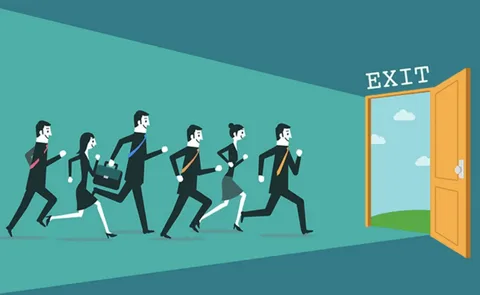

# Описание
##### В ноутбуке представлена модель прогнозирования оттока клиентов телеком компании. 
Эта задача очень важна на практике и алгоритмы для ее решения используются в реальных телеком компаниях, ведь если мы знаем, что клиент собирается уйти от нас, то мы попытаться удержать его, предложив какие-то бонусы. 

## Цель моделирования
#####  Создание максимально точного прогноза по установленной Заказчиком метрики ROC-AUC

## Файлы:
1. **train.csv** - содержит колонки признаков и целевую переменную
2. **test.csv** - содержит колонки признаков
3. **submission.csv** - пример файла с предсказанием

## Данные:
1. **ClientPeriod**: Содержит информацию о том, сколько полных месяцев клиент уже является клиентом компани
2. **MonthlySpending**: Содержит ежемесячный траты клиента на услуги компании (или траты нового клиента за месяц)
3. **TotalSpent**: Содержит общую сумму, которую клиент потратил за все время своего обслуживания в компании
4. **Sex**: Пол клиента
5. **IsSeniorCitizen**: Бинарная колонка, которая показывает, является ли клиент пенсионером
6. **HasPartner**: Указывает на наличие у клиента супруга
7. **HasChild**: Указывает на наличие детей у клиента
8. **HasPhoneService**: Указывает пользуется ли клиент услугой телефонной связи
9. **HasMultiplePhoneNumbers**: Указывает на наличие у клиента нескольких телефонных номеров
10. **HasInternetService**: Указывает пользуется ли клиент услугами предоставления интернет соединения
11. **HasOnlineSecurityService**: Указывает на наличие у клиента услуги онлайн-безопасности
12. **HasOnlineBackup**: Наличие у клиента услуги онлайн-резервирования данных
13. **HasDeviceProtection**: Наличие у клиента услуги защиты устройств
14. **HasTechSupportAccess**: Наличие у клиента доступа к технической поддержке
15. **HasOnlineTV**: Наличие у клиента услуги онлайн-телевидения
16. **HasMovieSubscription**: Наличие у клиента подписки на фильмы
17. **HasContractPhone**: Эта колонка, вероятно, указывает на наличие у клиента контракта (лизинга) телефона
18. **IsBillingPaperless**: Показывает, использует ли клиент электронными платёжками
19. **PaymentMethod**: Метод оплаты, используемом клиентом
20. **Churn**: Показывает, ушел ли клиент. Целевая переменная

Названия признаков и целевой пременной есть в baseline ноутбуке.


# EDA
EDA предствлена в минимальном наборе, так, как данные максимально подг

In [1]:
import numpy as np
import pandas as pd
import os, sys, gc, warnings, random, datetime, psutil

from matplotlib import pyplot as plt 
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split, KFold, GroupKFold
from sklearn.preprocessing import LabelEncoder

from catboost import CatBoostClassifier

warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', 20)

In [2]:
########################### Vars
SEED = 42


In [3]:
def preproc_num(train):
    train['NewClient'] = 0 # новый клиент
    train.loc[train['TotalSpent'] == ' ','NewClient'] = 1
    train.loc[train['TotalSpent'] == ' ','TotalSpent'] = 0
    train['TotalSpent'] = train['TotalSpent'].astype('float32')
    train['MonthlySpending'] = train['MonthlySpending'].astype('float32')          
    train['ClientPeriod'] = train['ClientPeriod'].astype('int16')
    train['IsSeniorCitizen'] = train['IsSeniorCitizen'].astype('bool')
    

    return train

# Загрузки и EDA

## Train

In [4]:
train = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/train.csv')
print(train.isna().sum())
print(train.info(all))
train.head()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
Churn                       0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int64  
 1   MonthlySpending           5282 non-null   float64
 2   TotalSpent                5282 non-null   object 
 3   

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0


In [5]:
print(train['IsSeniorCitizen'].unique())
print(train['Churn'].unique())

[0 1]
[0 1]


## Выводы Train
1. Число значений - 1761, данные чистые без nan
2. Нет ненужных фичей, индексов
3. TotalSpent - тип object, переделаем в float32
4. Есть несоответствие типов у фичи ('IsSeniorCitizen') и у таргета ('Churn'), которое будет устранено
5. Есть некая непринципиальная избыточность - ClientPeriod, IsSeniorCitizen, Churn - устранил функцией


## Test

In [6]:
test = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv') # Чтение тренировачных данных
print(test.isna().sum())
print(test.info(all))
print(test['IsSeniorCitizen'].unique())
test.head()

ClientPeriod                0
MonthlySpending             0
TotalSpent                  0
Sex                         0
IsSeniorCitizen             0
HasPartner                  0
HasChild                    0
HasPhoneService             0
HasMultiplePhoneNumbers     0
HasInternetService          0
HasOnlineSecurityService    0
HasOnlineBackup             0
HasDeviceProtection         0
HasTechSupportAccess        0
HasOnlineTV                 0
HasMovieSubscription        0
HasContractPhone            0
IsBillingPaperless          0
PaymentMethod               0
dtype: int64
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1761 entries, 0 to 1760
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              1761 non-null   int64  
 1   MonthlySpending           1761 non-null   float64
 2   TotalSpent                1761 non-null   object 
 3   Sex                       1761

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod
0,42,56.10,2386.85,Male,0,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic)
1,29,98.50,3004.15,Male,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check
2,9,76.25,684.85,Male,0,No,No,Yes,Yes,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
3,67,74.00,4868.4,Female,0,Yes,Yes,Yes,Yes,DSL,Yes,Yes,No,Yes,Yes,No,Two year,No,Credit card (automatic)
4,71,20.10,1389.6,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Bank transfer (automatic)


## Выводы Test
1. Число значений - 1761, данные чистые без nan
2. Нет ненужных фичей, индексов
3. TotalSpent - тип object, переделаем в float32
4. Есть несоответствие типов - 'IsSeniorCitizen', которое будет устранено
5. Есть некая непринципиальная избыточность - ClientPeriod, IsSeniorCitizen, Churn - устранил функцией

## Очистка

In [7]:
train['TotalSpent'].value_counts() # Смотрим какие значения встречаются в колонке

TotalSpent
           9
20.2       9
19.75      8
20.05      6
19.65      6
          ..
41.85      1
4326.25    1
950.2      1
4264       1
1375.6     1
Name: count, Length: 4978, dtype: int64

In [8]:
len(train[train['TotalSpent'] == ' '])

9

Есть 9 новых клиентов, у них **TotalSpent = ' '** т.е равен пробелу.
Обрабатываем их функцией **preproc_num()**
1. создаем столбец NewClient, что-бы оставить след
2. Меняем в TotalSpent пробел на 0


In [9]:
preproc_num(train)
train['Churn'] = train['Churn'].astype('bool')
train.head(2)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,NewClient
0,55,19.50,1026.349976,Male,False,Yes,Yes,Yes,No,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,False,0
1,72,25.85,1872.199951,Male,False,Yes,No,Yes,Yes,No,...,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),False,0


In [10]:
print(train.info(all))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5282 entries, 0 to 5281
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              5282 non-null   int16  
 1   MonthlySpending           5282 non-null   float32
 2   TotalSpent                5282 non-null   float32
 3   Sex                       5282 non-null   object 
 4   IsSeniorCitizen           5282 non-null   bool   
 5   HasPartner                5282 non-null   object 
 6   HasChild                  5282 non-null   object 
 7   HasPhoneService           5282 non-null   object 
 8   HasMultiplePhoneNumbers   5282 non-null   object 
 9   HasInternetService        5282 non-null   object 
 10  HasOnlineSecurityService  5282 non-null   object 
 11  HasOnlineBackup           5282 non-null   object 
 12  HasDeviceProtection       5282 non-null   object 
 13  HasTechSupportAccess      5282 non-null   object 
 14  HasOnlin

In [11]:
preproc_num(test)
test.head(2)

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,NewClient
0,42,56.099998,2386.850098,Male,False,Yes,No,Yes,Yes,DSL,Yes,No,No,No,No,No,One year,No,Credit card (automatic),0
1,29,98.500000,3004.149902,Male,True,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,0


In [12]:
test[test['TotalSpent'] == ' ']

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,NewClient


## Разделяем типы признаков

Выделили назначение и типы признаков

In [13]:
num_col = ['ClientPeriod', 'MonthlySpending', 'TotalSpent']
target_col = ['Churn']
delete_col = []
cat_col = [x for x in train.columns if x not in (num_col + target_col)]

In [14]:
print(cat_col)

['Sex', 'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService', 'HasMultiplePhoneNumbers', 'HasInternetService', 'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection', 'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription', 'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'NewClient']


Переходим к анализу данных

# Анализ данных

Построим для численных призанков гистограмму и boxplot (ящик с усами) 

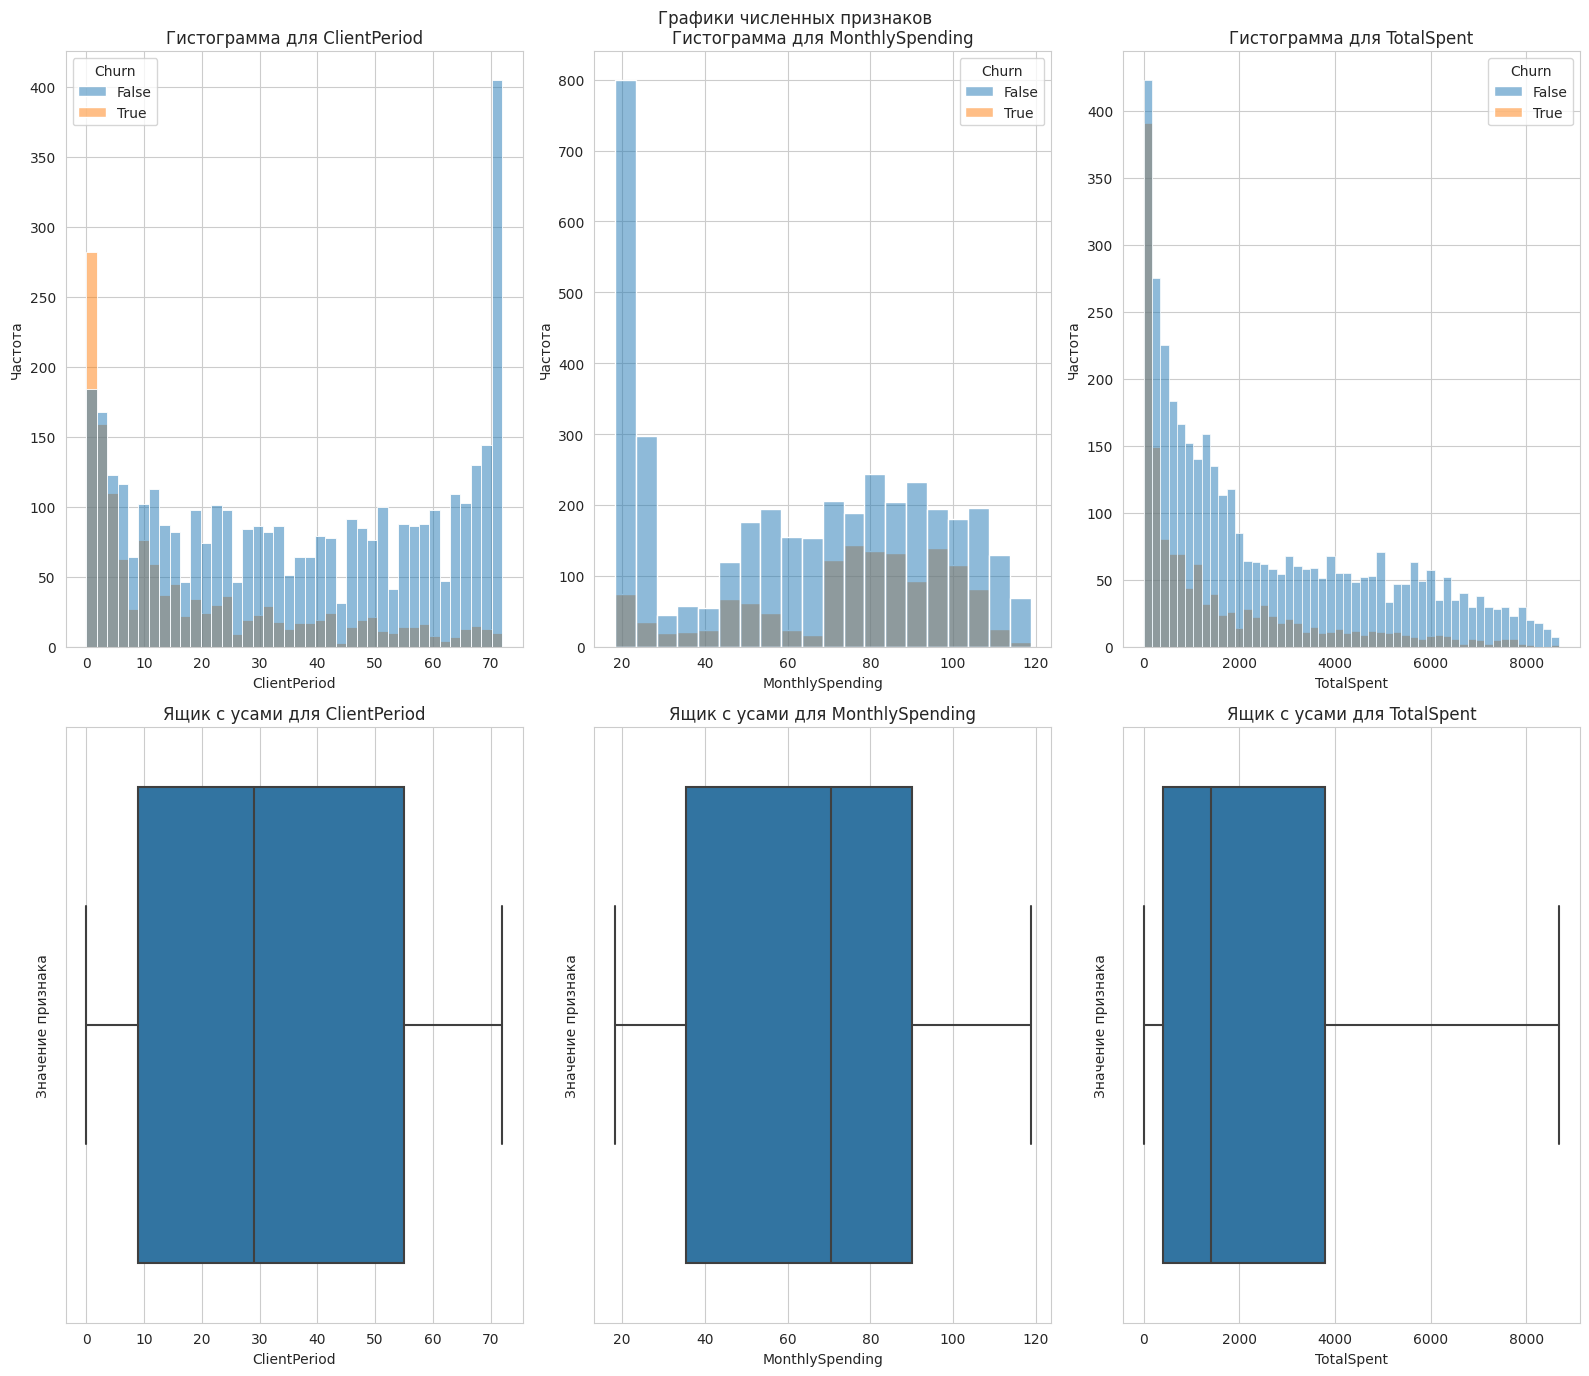

In [15]:
colors = ['red', 'green', 'blue'] # цвета по которым будем итерироваться
bins = [40, 20, 50] # количество корзин для гистограм для итерации
X_labels = ['ClientPeriod', 'MonthlySpending', 'TotalSpent'] # названия признаков для итерации
sns.set_style('whitegrid') # добавляем к графикам сетку
plt.figure(figsize=(16,14)) # создание полотна для подграфикоф
plt.suptitle('Графики численных признаков') # название полотна
for i in range(3): # запускаем цикл на 3 подграфика
    plt.subplot(2, 3, i+1) # задаём положение подграфика
    #sns.histplot(data=train[num_col + target_col], x=num_col[i], bins=bins[i], color=colors[i], hue='Churn') # создание гистограммы
    sns.histplot(data=train, x=num_col[i], bins=bins[i], color=colors[i], hue='Churn') # создание гистограммы
    plt.xlabel(X_labels[i]) # подписываем ось абсцисс
    plt.ylabel('Частота') # подписываем ось ординат
    plt.title(f'Гистограмма для {X_labels[i]}') # подписываем подграфик
for i in range(3): # запускаем цикл на 3 подграфика
    plt.subplot(2, 3, i+4) # задаём положжение подграфика
    sns.boxplot(data=train, x=num_col[i], hue='Churn') # создание гистограммы
    plt.xlabel(X_labels[i]) # подписываем ось абсцисс
    plt.ylabel('Значение признака') # подписываем ось ординат
    plt.title(f'Ящик с усами для {X_labels[i]}') # подписываем подграфик    
plt.tight_layout()
plt.show()

Построим круговые графики для категориальных и булевых признаков круговые диаграммы.

In [16]:
len(cat_col)

17

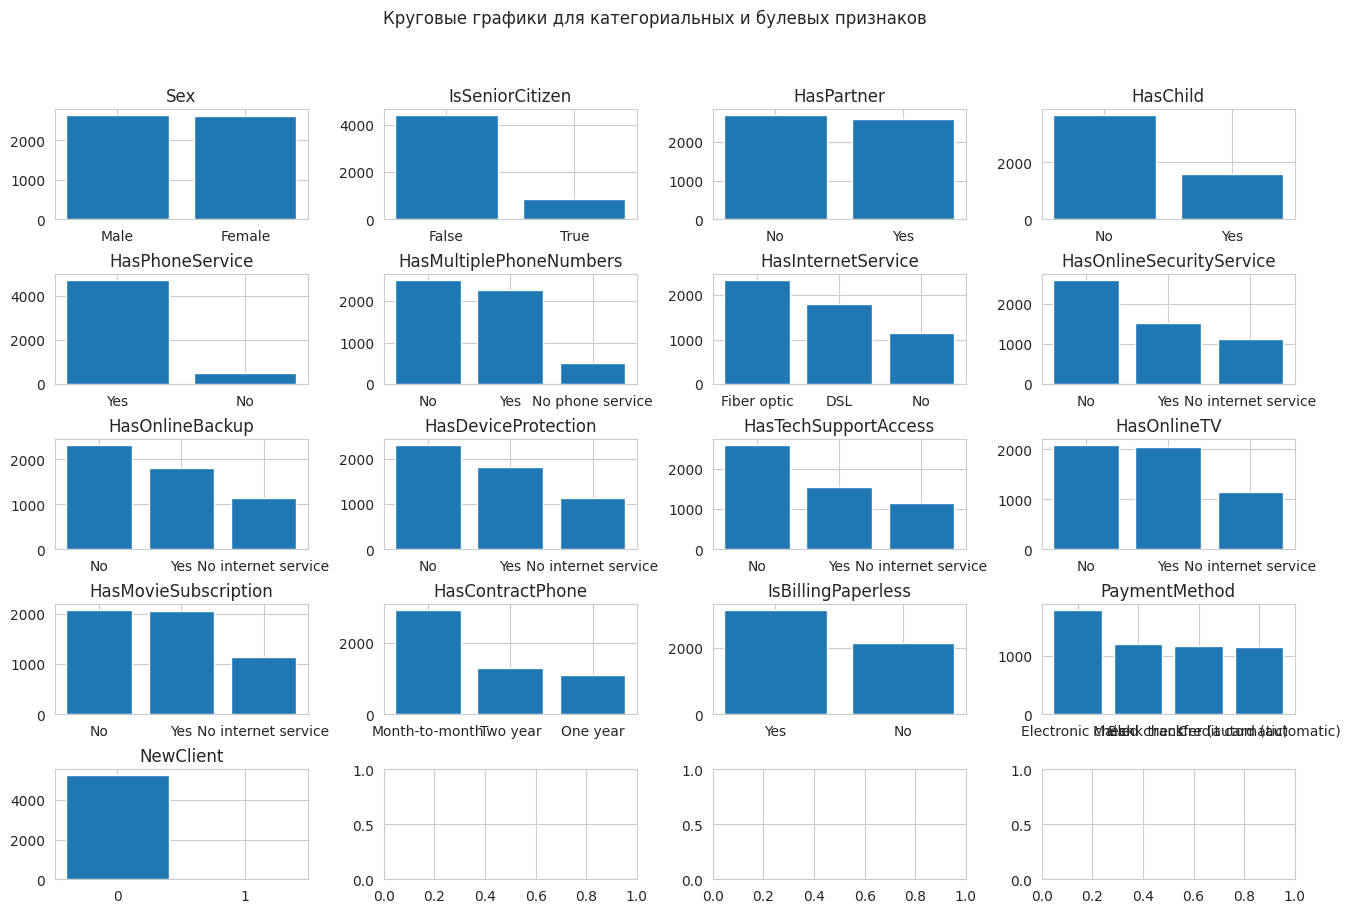

In [17]:
##cat_and_bool = bool_features + cat_features # конкатенируем булевы и категориальные признаки, чтобы по ним можно было итерироваться
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(16, 10)) # Returns fig : `.Figure` ax : `~matplotlib.axes.Axes` or array of Axes
ax_array = axes.ravel() # ravel() из массива 3х3 делает 1х9. Нужно для итерации
fig.suptitle('Круговые графики для категориальных и булевых признаков') # подпись полотна
for i, feature in enumerate(cat_col): # итерация по списку признаков
    x = train[feature].value_counts() #  "Раскладываем" каждый признак на количество его уникальных значений
    n = x.index # Присваиваем список возможных уникальных значений. Для биноминальных это 1 и 0, для категориальных его возможные значения
    ax_array[i].bar(x=x.index, height=x, tick_label=n) # Строим круговую диаграмму
    ax_array[i].set_title(feature)  # Подписываем диаграмму

plt.subplots_adjust(hspace=0.5, wspace=0.3)

Также построим круговую диаграмму для отклика, чтобы понять сбалансированны ли классы

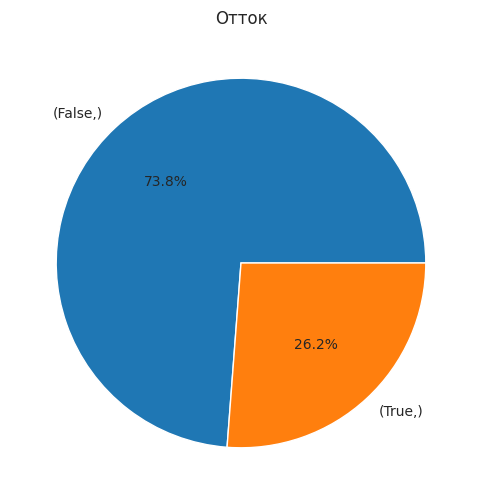

In [18]:
x = train[target_col].value_counts() 
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
n = x.index
axes.pie(x=x, labels=n, autopct='%.1f%%')
axes.set_title('Отток') 
plt.show()

Отношение классов в нашей выборки ~1/3, а следовательно выборку нельзя считать сбалансированной.

Построим тепловую карту корреляций признаков в нашей выборку

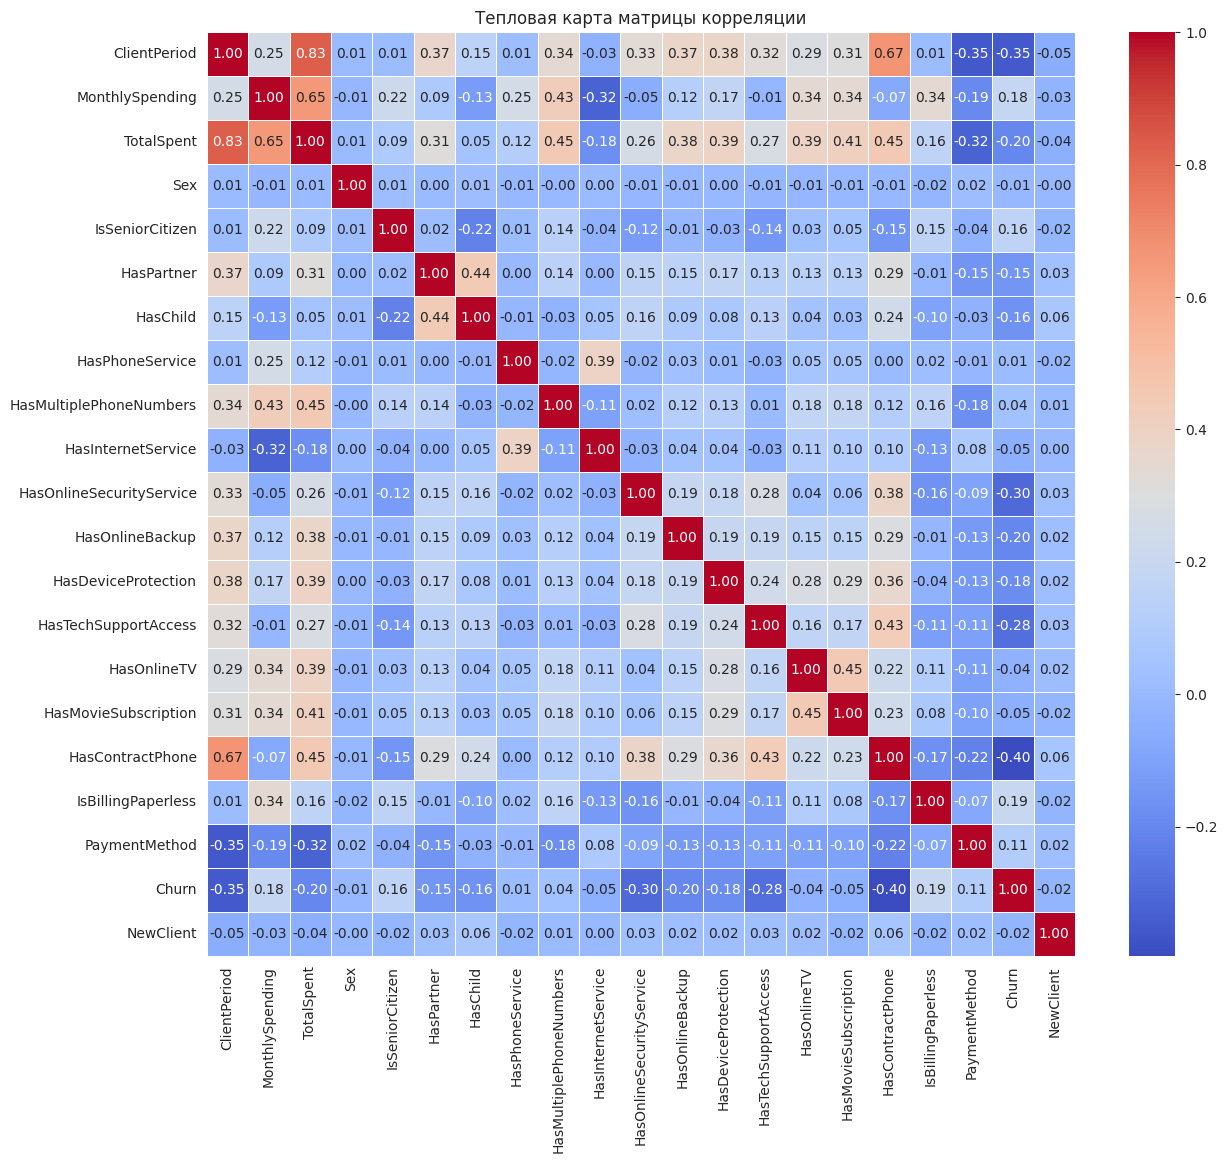

In [19]:
from sklearn.preprocessing import LabelEncoder # импортируем кодировку признаков чтобы можно было использовать np.corr()
corr_matrix = train.copy() # копируем нашу таблицу
label_encoder = LabelEncoder() # загружаем LabelEncoder
for cat_feature in cat_col: # делаем цикл т.к. LabelEncoder может кодировать только 1 колонку за раз
    corr_matrix[cat_feature] = label_encoder.fit_transform(corr_matrix[cat_feature])

corr_matrix = corr_matrix.corr() # используем метод np.corr() на закодированную таблицу
plt.figure(figsize=(14, 12))  # строим полотно для тепловой карты
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt='.2f') # строим тепловую карту
plt.title('Тепловая карта матрицы корреляции') # подписываем карту
plt.show()

По тепловой карте матрицы корреляции видно, что с целевым парметром сильнее всех отрицательно коррелирует наличие контракта на телефон (-0.4) и длительность пользования услугами компании (-0.35). Сильнее всех положительно коррелирует наличие электронной платёжки (0.19) и величина месячных трат на услуги (0.18). Меньше всех с целевым признаком коррелирует пол клиента (0.01) и пользование телефонными услугами (0.01)

### Но в целом, корреляции не очень хороший аргумент, главное правило - добавляет фича в скор или нет. 
### Если добавление фичи уменьшает скор - ее не должно быть.

# Применение линейных моделей 

In [20]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

In [21]:
# разбиваем наши данные на признаки и отклик
y_tr = train[target_col] # отклик
x_tr = train[num_col + cat_col] # признаки

In [22]:
x_te = test

Для логистической регрессии нам необходимо отнормировать числовые признаки. Воспользуемся StandardScaler. 

In [23]:
# Код ниже может вызвать некритичные предупреждения. И, чтобы красное полотно текста нас не смущало, проигнорируем их.
import warnings
warnings.filterwarnings('ignore')

In [24]:

hyperparams = [{'LogReg__C': [30, 40, 50],
                'LogReg__penalty': ['l2'],
                'LogReg__solver': ['lbfgs'], 
                'LogReg__max_iter': [100, 120, 140]}] # лучшие параметры из итерируемых
preprocess = ColumnTransformer([ # применяем стандартную нормировку к числовым признакам и OHE к категориальным
        ("num", StandardScaler(), num_col),
        ("cat_ohe", OneHotEncoder(drop="first"), cat_col)
    ])
pipe = Pipeline([ # создаём конвеер
        ("preprocess", preprocess),
        ("LogReg", LogisticRegression(random_state=42))
    ])
logreg = GridSearchCV(pipe, hyperparams, scoring='roc_auc', refit=True, n_jobs=-1, cv=5) # выполнение кросс-валидации
logreg.fit(x_tr, y_tr.values.ravel())
print(f'Итоговые параметры:', logreg.best_params_)
print(f'Лучшая оценка:', round(logreg.best_score_,4))

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

Итоговые параметры: {'LogReg__C': 40, 'LogReg__max_iter': 140, 'LogReg__penalty': 'l2', 'LogReg__solver': 'lbfgs'}
Лучшая оценка: 0.8452


Итоговые параметры: {'clf__C': 10, 'clf__max_iter': 100, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs'}
Лучшая оценка: 0.845150104886311

Теперь надо загрузить тестовую выборку и сделать оценку вероятности

In [25]:
"""x_te = pd.read_csv('/kaggle/input/advanced-dls-spring-2021/test.csv') # загружаем тестовую выборку
preproc_num(X_test) # применяем напписанные нами ранее функции к тестовой выборке
preproc_bool(X_test)"""
logreg.predict_proba(x_te) # вызываем обученную модель для предсказания вероятности принадлежанию классу
pred_log = pd.Series(logreg.predict_proba(x_te)[:, 1]) # присваиваем рузльтат предсказания модели (только принадлеждности к 1му классу)
print(pred_log.shape)
pred_log.head()


pred_log = pd.DataFrame({
    'Id': range(len(pred_log)),
    'Churn': pred_log
    })
pred_log.to_csv('subm_log.csv', index=False)
pred_log

(1761,)


,Id,Churn
0,0,0.037171
1,1,0.735059
2,2,0.683521
3,3,0.005696
4,4,0.001209
...,...,...
1756,1756,0.098553
1757,1757,0.025980
1758,1758,0.751367
1759,1759,0.643720


#### Скор на ЛБ - 0.84586

# Применение градиентного бустинга

In [26]:
!pip install catboost

In [27]:
from catboost import CatBoostClassifier, CatBoostRegressor, Pool
from sklearn.model_selection import KFold  # k-фолдная валидация

In [28]:
n_splits = 10  # Число фолдов. Оптимально 3, 5 или 10
clfs = [] # Тут будем сохранять модели
scores = [] # Тут будем хранить скоры валидационных фолдов

# параметры валидации, обучение будет идти на n_splits фолдах
###X = train[filtered_features].drop(targets, axis=1, errors="ignore")
###y = train["target_class"]

kf = KFold(n_splits=n_splits, shuffle=True, random_state=SEED)
for train_index, test_index in kf.split(x_tr):

    x_tr_fld, x_te_fld = x_tr.iloc[train_index], x_tr.iloc[test_index]
    y_tr_fld, y_te_fld = y_tr.iloc[train_index], y_tr.iloc[test_index]
    
    # Специальный класс для ускорения обучения
    train_dataset = Pool(data=x_tr_fld, label=y_tr_fld, cat_features=cat_col)
    eval_dataset = Pool(data=x_te_fld, label=y_te_fld, cat_features=cat_col)

    clf = CatBoostClassifier(
        depth=4,
        iterations=400,
        #learning_rate=0.5,
        loss_function="Logloss",  # MultiLogloss
        eval_metric = 'AUC:hints=skip_train~false', ####'Precision',  F1:macro / AUC:hints=skip_train~false
        custom_metric= 'AUC', ###["Recall"],  # 'AUC / Accuracy,

        # Главная фишка катбуста - работа с категориальными признаками
        cat_features=cat_col,
        # ignored_features = ignored_features,

        # Регуляризация и ускорение
        colsample_bylevel=0.098,
        subsample=0.95,
        l2_leaf_reg=1,
        #min_data_in_leaf=243,
        #max_bin=187,
        random_strength=1,

        # Параметры скорения
        task_type="CPU",
        thread_count=-1,
        #bootstrap_type="Bernoulli",

        # Важное!
        random_seed=SEED,
        auto_class_weights="SqrtBalanced",
        early_stopping_rounds=40)

    clfs.append(clf)

    clf.fit(
        train_dataset,
        eval_set=eval_dataset,
        verbose=500,
        use_best_model=True,
        plot=False)
    
    print(clf.best_score_["validation"].items())
    
    scores.append(np.mean([v for k, v in clf.best_score_["validation"].items() if "AUC" in k], dtype="float16"))
    # scores.append(clf.best_score_['validation']['MultiClass'])
    # clf.save_model("../tmp_data/cool_catboost_model_{}_deep".format(n))

assert len(clfs) == n_splits
print("mean AUC score --------->", np.mean(scores, dtype="float16") - np.std(scores, dtype="float16"))
scores

0:	learn: 0.7998711	test: 0.7362651	best: 0.7362651 (0)	total: 64.5ms	remaining: 25.7s
399:	learn: 0.8692854	test: 0.8045813	best: 0.8045813 (397)	total: 2.29s	remaining: 0us

bestTest = 0.8045813441
bestIteration = 397

Shrink model to first 398 iterations.
dict_items([('Logloss', 0.5143460951329686), ('AUC', 0.8045813441057657)])
0:	learn: 0.7999010	test: 0.8022907	best: 0.8022907 (0)	total: 8.14ms	remaining: 3.25s
Stopped by overfitting detector  (40 iterations wait)

bestTest = 0.8516624041
bestIteration = 18

Shrink model to first 19 iterations.
dict_items([('Logloss', 0.49566337565528557), ('AUC', 0.8516624040920716)])
0:	learn: 0.7489189	test: 0.7503503	best: 0.7503503 (0)	total: 6.31ms	remaining: 2.52s
399:	learn: 0.8631510	test: 0.8527220	best: 0.8529454 (386)	total: 2.22s	remaining: 0us

bestTest = 0.8529453571
bestIteration = 386

Shrink model to first 387 iterations.
dict_items([('Logloss', 0.4471927000076318), ('AUC', 0.8529453570775885)])
0:	learn: 0.7609787	test: 0.71381

[0.8047, 0.8516, 0.853, 0.826, 0.831, 0.8447, 0.8784, 0.8643, 0.8447, 0.8765]

In [29]:
subm_cat0 = pd.Series(clf.predict_proba(x_te)[:, 1])
subm_cat0 = pd.DataFrame({
    'Id': range(len(subm_cat0)),
    'Churn': subm_cat0
    })
subm_cat0.to_csv('subm_cat0.csv', index=False)

#### Скор на ЛБ - 0.84185

In [30]:
subm_cat1 = pd.Series(clf.predict_proba(x_te)[:, 1])
subm_cat1 = pd.DataFrame({
    'Id': range(len(subm_cat1)),
    'Churn': subm_cat1
    })
subm_cat1.to_csv('subm_cat1.csv', index=False)

#### Скор на ЛБ - 0.84409

In [31]:
params = {'depth': [4],
          'random_seed': [42],
          'l2_leaf_reg': [1],
          'iterations': [200],
          'subsample': [0.5],
          'learning_rate': [0.05],
          'grow_policy': ['Lossguide']} # лучшие найденные параметры
catboost = CatBoostClassifier(silent=True, cat_features=cat_col, eval_metric = 'AUC:hints=skip_train~false',)
best_params = catboost.grid_search(params, x_tr, y_tr, refit=True)


bestTest = 0.8724540487
bestIteration = 82

0:	loss: 0.8724540	best: 0.8724540 (0)	total: 2.17s	remaining: 0us
Estimating final quality...
Training on fold [0/3]

bestTest = 0.8370646021
bestIteration = 142

Training on fold [1/3]

bestTest = 0.8481328036
bestIteration = 168

Training on fold [2/3]

bestTest = 0.858874422
bestIteration = 62



In [32]:
print('Лучшие параметры: ',best_params['params'])

Лучшие параметры:  {'depth': 4, 'random_seed': 42, 'l2_leaf_reg': 1, 'iterations': 200, 'subsample': 0.5, 'learning_rate': 0.05, 'grow_policy': 'Lossguide'}


In [33]:

subm_cat2 = pd.Series(catboost.predict_proba(x_te)[:, 1])
subm_cat2 = pd.DataFrame({
    'Id': range(len(subm_cat2)),
    'Churn': subm_cat2
    })
subm_cat2.to_csv('subm_cat2.csv', index=False)

#### Скор на ЛБ - 0.85454

# Feature Importance

In [34]:
x_tr.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'NewClient'],
      dtype='object')

#### Печать важности признаков, придуманный мной признак оказался бесполезен:)

In [35]:
##df_feature_importance = pd.DataFrame(data=model3.get_feature_importance(), columns=fin_list)
df_feature_importance = pd.DataFrame(data=list(catboost.get_feature_importance()), index=x_tr.columns)
display(df_feature_importance.sort_values(by=0, ascending=False).head(20))
#df_feature_importance.sort_values(by=0, ascending=False).tail(10)


,0
HasContractPhone,33.980754
ClientPeriod,15.665594
HasOnlineSecurityService,9.865937
HasInternetService,8.238705
MonthlySpending,7.256039
TotalSpent,6.129240
PaymentMethod,5.691923
HasTechSupportAccess,3.092967
HasOnlineBackup,2.066298
HasMovieSubscription,1.539652


# LightGBM


Вначале применим LabelEncoder(), в общем никаких изменений для CatBoost он не несет.

In [36]:
# переведем категориальные фичи в int с помощью  LabelEncoder
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
for col in cat_col:
    x_tr[col] = le.fit_transform(x_tr[col])
    
for col in cat_col:
    x_te[col] = le.fit_transform(x_te[col])

# таргет так же придется перевести из строкового типа в целочисленный
le_tar = LabelEncoder()
y_tr = le_tar.fit_transform(y_tr)

In [37]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_tr, y_tr, test_size=0.2, random_state=42,)

In [38]:
from lightgbm import Dataset

train_data = Dataset(
    x_train,
    y_train,
    categorical_feature=cat_col,
    free_raw_data=False,
)

# Еще валидационный датасет для настройки ранней остановки
val_data = Dataset(
    x_valid,
    y_valid,
    categorical_feature=cat_col,
    free_raw_data=False,
)

In [39]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score

params = {
    "objective": "binary",
    "metric": "auc",
    'n_estimators': 200,
    'learning_rate': 0.02,
    "verbosity": -1,
    'cat_feature': cat_col,
    
}

booster = LGBMClassifier(
    **params)
booster.fit(x_train,
            y_train,
            eval_set=[(x_valid,y_valid)],
            early_stopping_rounds=10,
            categorical_feature=cat_col
           )
###x_train, x_valid, y_train, y_valid
valid_preds = booster.predict(x_valid)  # Use raw data for prediction
print("\nTest Accuracy: %.2f" % accuracy_score(y_valid, valid_preds))

subm_lgbm1 = pd.Series(booster.predict_proba(x_te)[:, 1])
subm_lgbm1 = pd.DataFrame({
    'Id': range(len(subm_lgbm1)),
    'Churn': subm_lgbm1
    })
subm_lgbm1.to_csv('subm_lgbm1.csv', index=False)

[1]	valid_0's auc: 0.813975
[2]	valid_0's auc: 0.813026
[3]	valid_0's auc: 0.813871
[4]	valid_0's auc: 0.813116
[5]	valid_0's auc: 0.812968
[6]	valid_0's auc: 0.813164
[7]	valid_0's auc: 0.814358
[8]	valid_0's auc: 0.815085
[9]	valid_0's auc: 0.816046
[10]	valid_0's auc: 0.816069
[11]	valid_0's auc: 0.816556
[12]	valid_0's auc: 0.817914
[13]	valid_0's auc: 0.818666
[14]	valid_0's auc: 0.819823
[15]	valid_0's auc: 0.819938
[16]	valid_0's auc: 0.820566
[17]	valid_0's auc: 0.820342
[18]	valid_0's auc: 0.820564
[19]	valid_0's auc: 0.819941
[20]	valid_0's auc: 0.819915
[21]	valid_0's auc: 0.81983
[22]	valid_0's auc: 0.820516
[23]	valid_0's auc: 0.82058
[24]	valid_0's auc: 0.820269
[25]	valid_0's auc: 0.820532
[26]	valid_0's auc: 0.820195
[27]	valid_0's auc: 0.819973
[28]	valid_0's auc: 0.819945
[29]	valid_0's auc: 0.820172
[30]	valid_0's auc: 0.820146
[31]	valid_0's auc: 0.820192
[32]	valid_0's auc: 0.82013
[33]	valid_0's auc: 0.820416

Test Accuracy: 0.74


#### Скор на ЛБ 0.84689

#### Сделаем блендинг из 3-х моделей.

In [40]:
subm_fin = pred_log
subm_fin['Churn'] = (0.84586 * pred_log['Churn'] + 0.85454 * subm_cat2['Churn'] + 0.84689 * subm_lgbm1['Churn']) / (0.84586 + 0.85454 + 0.84689 )

subm_fin.to_csv('subm_fin2.csv', index=False)

In [41]:
subm_fin.head(2)

,Id,Churn
0,0,0.084495
1,1,0.610908


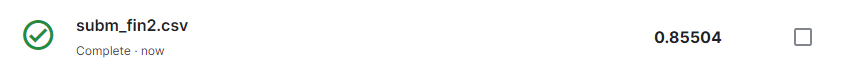

#### С помощью такой не очень сильной оптимизации и блендинга получился скор - 0.85584.

Правилами Kaggle допускается использовать расшаренные датасеты, и таким образом можно получить результаты - 0.89 и выше.